In [1]:
import matplotlib.pyplot as plt
import os, sys

from astropy.io import fits

import numpy as np

import matplotlib.colors as colors
from astropy.visualization import imshow_norm, MinMaxInterval, LogStretch,PercentileInterval, ImageNormalize

import sep

sys.path.append('/home/kevin/repos/ReipurthBallyProject/src')

import chan_info as ci

rootdir = '/home/kevin/Documents/ZCMa-2014-12-18/W-S-I+'

In [39]:
def show_image(img, ax=None):

    norm = ImageNormalize(img,
                            interval=PercentileInterval(99.5),
                            stretch=LogStretch(1000))
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(4,8))
    ax.imshow(img, cmap='grey', origin='lower', norm=norm)

In [20]:
fitspath = os.path.join(rootdir, 'calibrated', 'SUPA01499555.fits')
img_hdr, img_data = ci.get_fits(fitspath)



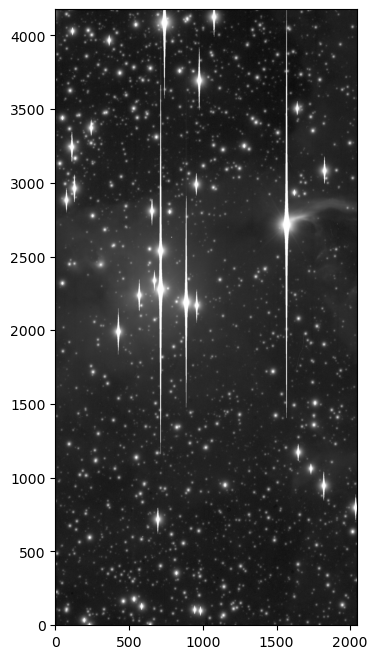

In [37]:
show_image(img_data)

In [19]:
def df2reg(df, regpath, name_root='Region'):
    reg_hdr = ['# Region file format: DS9 version 4.1',
               'global color=red dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1',
               'physical']
    hasnames = 'name' in df.columns
    if hasnames:
        names = df.name
    else:
        names = [f'{name_root}_{i:02d}' for i in range(len(df))]

    with open(regpath,'w') as regf:
        for h in reg_hdr:
            regf.write(h+'\n')
    
        for name, reg in zip(names, df.itertuples()):
            nametxt = '{' + name + '}'
            reg_str = f'circle({reg.x_pos}, {reg.y_pos}, {reg.radius}) # text={nametxt}'
            regf.write(reg_str+'\n')

In [59]:
import pandas as pd
from astropy.table import Table

def find_stars(data,  regout=None, thresh = 50):

    img_data = data; #data.byteswap().newbyteorder()
    img_bkg = sep.Background(img_data)
    bkg_img =img_bkg.back()
    img_sub = img_data - bkg_img
    objects = sep.extract(img_sub, thresh, err=img_bkg.globalrms)
    print(f'Number of objects identified: {len(objects)}')
    objects_tbl = Table(objects, meta={'ExtractionThreshold': thresh, 'err': img_bkg.globalrms})
    reg_df = pd.DataFrame({'x_pos':objects_df.x+1, 'y_pos':objects_df.y+1,'radius':8})
    if regout is not None:
        ds9tbl = objects_tbl[['x', 'y', 'flux', 'npix']]
        ds9tbl.meta=objects_tbl.meta
        #ds9 uses fits indexing (1-relative)
        ds9tbl['x'] += 1
        ds9tbl['y'] += 1
        ds9tbl.write(regout, table_id= 'objects',format = 'votable', overwrite=True)
        
    return objects_tbl

In [60]:
catpath = os.path.join(rootdir, 'objcat', 'SUPA01499555.xml')
objects_tbl = find_stars(img_data, catpath)

Number of objects identified: 698


In [51]:
objects_tbl

thresh,npix,tnpix,xmin,xmax,ymin,ymax,x,y,x2,y2,xy,errx2,erry2,errxy,a,b,theta,cxx,cyy,cxy,cflux,flux,cpeak,peak,xcpeak,ycpeak,xpeak,ypeak,flag
float64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64
77.77119445800781,8,2,1022,1025,0,1,1023.3241275982214,0.3329365499838678,0.71817702644452,0.2220898036687073,-7.015740203769605e-05,1.0359744720300255e-07,2.2476452365963365e-08,2.376306322138472e-09,0.847453236579895,0.4712640345096588,-0.00014142150757834315,1.3924144506454468,4.502683162689209,0.0008797178161330521,15469.7080078125,20619.185546875,4325.02587890625,13961.8642578125,1023,0,1023,0,2
77.77119445800781,33,33,1786,1791,1,6,1788.4060542064578,3.367671628398103,2.3286707146126693,2.3738283917852607,0.1525783634011546,1.7322799470798527e-05,1.734185715980088e-05,1.2265944144154621e-06,1.582873821258545,1.4822312593460083,0.8588560223579407,0.43124568462371826,0.42304205894470215,-0.05543683096766472,3467.124755859375,3601.293212890625,140.2368621826172,151.87509155273438,1788,3,1788,3,0
77.77119445800781,375,370,217,249,0,14,232.71849659490533,4.71542954513688,18.50011562989789,12.391088960472949,-1.0950115656037696,5.325413186778988e-07,1.3514844670043988e-07,6.616530145342401e-09,4.323246479034424,3.4929563999176025,-0.1721089631319046,0.054337937384843826,0.08112750202417374,0.00960378348827362,333486.625,344647.8125,3104.814208984375,3164.858642578125,235,1,236,0,2
77.77119445800781,30,30,1117,1122,10,15,1119.332374311675,12.507125530904101,2.0070129697033297,2.2963842534502987,0.015272649031370378,1.719595699611651e-05,1.947480613008522e-05,-5.287913321180544e-11,1.5156477689743042,1.4164071083068848,1.5182123184204102,0.49827811121940613,0.4354892373085022,-0.006627833936363459,3062.598388671875,3188.532958984375,132.83511352539062,143.95916748046875,1119,12,1119,13,0
77.77119445800781,90,88,622,632,6,16,626.0256558946332,11.217000077168361,6.29630075733273,5.989232597511027,-0.562222749292058,1.1998802697737812e-05,1.1619653174419952e-05,-1.1796053883788323e-06,2.593371629714966,2.3579561710357666,-0.6521061062812805,0.1601659655570984,0.16837768256664276,0.03007028065621853,11754.833984375,11905.7939453125,232.39404296875,242.84591674804688,626,11,626,12,1
77.77119445800781,373,365,630,655,0,17,643.0064444899339,4.582219221825009,16.49119641299791,11.752754800058412,0.3291572286682509,6.563444501466503e-07,4.207918315179985e-07,1.424147024771139e-09,4.063736438751221,3.4249086380004883,0.06902346760034561,0.0606723316013813,0.08513402193784714,-0.00339847756549716,246597.75,252648.59375,3111.598388671875,3153.234375,642,3,641,3,3
77.77119445800781,76,73,1703,1712,14,23,1707.3260508965811,18.33124210260644,4.548043738298674,5.145959609362475,0.20295420937033626,8.970886118106414e-06,1.0053455950491577e-05,4.5069324814258026e-07,2.282179117202759,2.117938280105591,1.2725938558578491,0.22026240825653076,0.19466982781887054,-0.01737409085035324,10819.7333984375,11047.6484375,256.7010803222656,276.6399230957031,1707,18,1707,18,0
77.77119445800781,34,34,566,571,25,31,568.4633784044584,27.682464637443356,2.154149685880869,2.7042638750946466,0.022741375802449504,1.4504087976265969e-05,1.8561469498236618e-05,5.250604605472322e-09,1.6447499990463257,1.4673824310302734,1.5295507907867432,0.4642615020275116,0.3698192238807678,-0.007808369118720293,3665.426025390625,3811.072509765625,143.97853088378906,156.39414978027344,568,28,568,28,0
77.77119445800781,14,14,527,530,29,32,528.2776072307227,30.47265258955783,1.0093852288255132,1.0716945866259415,0.007028462649802059,2.310999205379345e-05,2.4124735921077937e-05,4.8277521297702905e-09,1.0356049537658691,1.0042918920516968,1.4598541259765625,0.9907472729682922,0.9331442713737488,-0.012995176948606968,1247.182373046875,1310.8134765625,101.57392883300781,111.78640747070312,528,30,528,30,0


In [63]:
from astropy.io.votable import parse_single_table
def load_obj_catalog__(cat_path):
    # cat_path = os.path.join(self.dirs['xmatch_tables'], img_name+'.xml')
    try:
        catalog = parse_single_table(cat_path).to_table()

    except:
        catalog = None
    return  catalog

In [64]:
test_cat = load_obj_catalog__(catpath)

In [66]:
test_cat.meta

{'ID': 'objects'}

In [67]:
Table.write.help()


Table.write general documentation

Write this Table object out in the specified format.

This function provides the Table interface to the astropy unified I/O
layer.  This allows easily writing a file in many supported data formats
using syntax such as::

  >>> from astropy.table import Table
  >>> dat = Table([[1, 2], [3, 4]], names=('a', 'b'))
  >>> dat.write('table.dat', format='ascii')

Get help on the available writers for ``Table`` using the``help()`` method::

  >>> Table.write.help()  # Get help writing Table and list supported formats
  >>> Table.write.help('fits')  # Get detailed help on Table FITS writer
  >>> Table.write.list_formats()  # Print list of available formats

The ``serialize_method`` argument is explained in the section on
`Table serialization methods
<https://docs.astropy.org/en/latest/io/unified.html#table-serialization-methods>`_.

See also: https://docs.astropy.org/en/stable/io/unified.html

Parameters
----------
*args : tuple, optional
    Positional argume

In [61]:
objects_tbl.meta

{'ExtractionThreshold': 50, 'err': 1.5554238557815552}

In [41]:
objects_df.columns

Index(['thresh', 'npix', 'tnpix', 'xmin', 'xmax', 'ymin', 'ymax', 'x', 'y',
       'x2', 'y2', 'xy', 'errx2', 'erry2', 'errxy', 'a', 'b', 'theta', 'cxx',
       'cyy', 'cxy', 'cflux', 'flux', 'cpeak', 'peak', 'xcpeak', 'ycpeak',
       'xpeak', 'ypeak', 'flag'],
      dtype='object')

In [62]:
img_bkg = sep.Background(img_data)
img_bkg.globalback, img_bkg.globalrms

(99.87477111816406, 1.5554238557815552)

In [35]:
np.sqrt((img_bkg.back()**2).mean())

101.35305

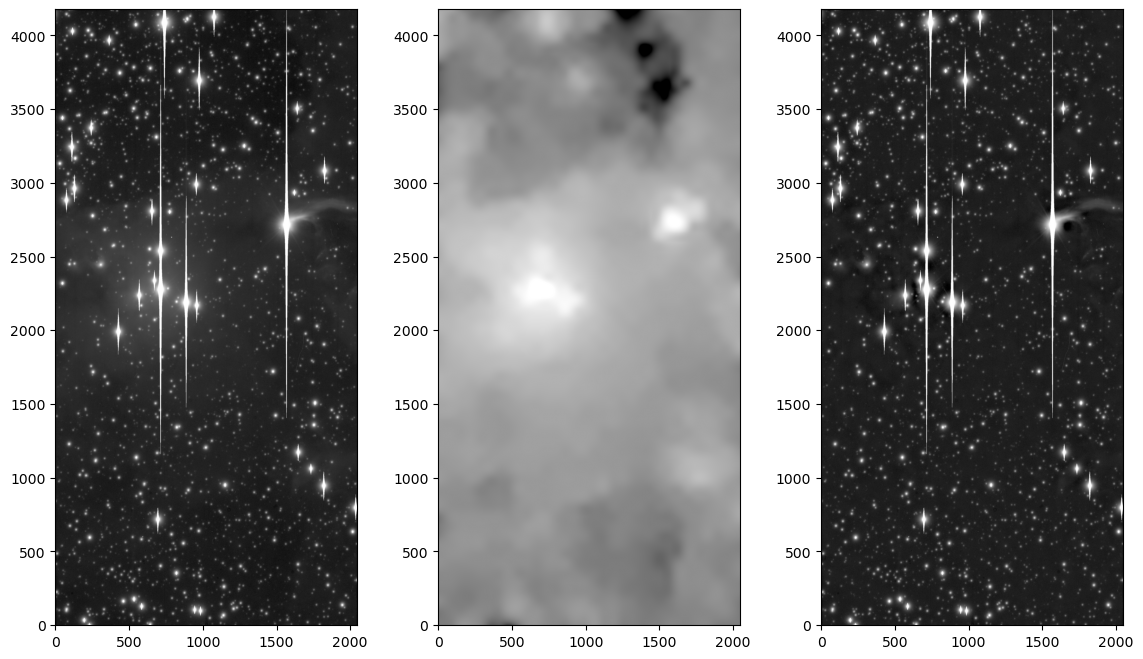

In [40]:
fig, axs= plt.subplots(ncols=3, figsize = (14,8))
show_image(img_data, axs[0])
show_image(img_bkg.back(), axs[1])
show_image(img_data-img_bkg.back(), axs[2])

In [61]:
bkg_img =img_bkg.back()
img_sub = img_data - bkg_img
img_sub, mask = cosmicray_lacosmic(img_sub)
objects = sep.extract(img_sub, 50, err=img_bkg.globalrms)

len(objects)

75

In [ ]:
import pandas as pd
objects_df = pd.DataFrame(objects)
objects_df

In [62]:
#stars = np.logical_and(objects_df.npix >= 150, objects_df.npix < 300)
reg_df = pd.DataFrame({'x_pos':objects_df.x+1, 'y_pos':objects_df.y+1,'radius':8})
df2reg(reg_df, '/home/kevin/Documents/N1333/N-A-L671/sep.reg')

In [27]:
objects_df.columns

Index(['thresh', 'npix', 'tnpix', 'xmin', 'xmax', 'ymin', 'ymax', 'x', 'y',
       'x2', 'y2', 'xy', 'errx2', 'erry2', 'errxy', 'a', 'b', 'theta', 'cxx',
       'cyy', 'cxy', 'cflux', 'flux', 'cpeak', 'peak', 'xcpeak', 'ycpeak',
       'xpeak', 'ypeak', 'flag'],
      dtype='object')

In [63]:
objects_df.describe()

,thresh,npix,tnpix,xmin,xmax,ymin,ymax,x,y,x2,...,cxy,cflux,flux,cpeak,peak,xcpeak,ycpeak,xpeak,ypeak,flag
count,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,...,104.000000,1.040000e+02,1.040000e+02,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000
mean,2897.461426,284.836538,256.230769,876.692308,901.971154,1961.028846,1988.759615,894.100837,1976.182369,213.244168,...,-0.379554,1.791711e+07,1.806350e+07,26372.571007,30650.353952,894.182692,1978.144231,894.201923,1978.096154,1.288462
std,0.000000,2168.834782,1933.323986,719.314885,722.515004,1289.698305,1314.560626,716.672072,1301.978331,2133.980980,...,1.714196,1.708514e+08,1.720552e+08,49085.602966,49544.622691,716.913771,1304.032919,716.898679,1303.794816,2.945041
min,2897.461426,5.000000,3.000000,0.000000,0.000000,0.000000,6.000000,0.000000,2.471942,0.071513,...,-8.301023,1.460816e+04,2.268148e+04,2931.119141,4249.408203,0.000000,1.000000,0.000000,0.000000,0.000000
25%,2897.461426,7.000000,6.000000,248.500000,267.500000,914.500000,918.750000,263.769528,916.847556,0.379805,...,-0.052954,2.458257e+04,3.459100e+04,4317.448486,7010.601562,263.500000,917.000000,263.500000,917.250000,0.000000
50%,2897.461426,16.000000,13.000000,676.000000,712.000000,1833.000000,1839.000000,709.626298,1836.428800,0.905036,...,-0.005217,6.354279e+04,7.651195e+04,5889.029053,10637.668945,709.500000,1836.500000,709.500000,1836.500000,0.000000
75%,2897.461426,66.000000,61.000000,1581.750000,1723.000000,2979.000000,3209.500000,1586.547414,3103.721519,3.253009,...,0.002839,6.498321e+05,6.640850e+05,17685.601074,22344.247559,1589.750000,3207.750000,1589.000000,3207.000000,1.000000
max,2897.461426,22142.000000,19741.000000,2047.000000,2047.000000,4160.000000,4176.000000,2047.000000,4163.008529,21766.088943,...,3.113304,1.743193e+09,1.755498e+09,198094.218750,198102.562500,2047.000000,4163.000000,2047.000000,4163.000000,10.000000


In [71]:
fitspath = os.path.join(rootdir,)

'/home/kevin/Documents/ZCMa-2014-12-18/W-S-I+/objcat/SUPA01499555.xml'

In [7]:
fitspath = os.path.join(rootdir, 'calibrated', 'SUPA01499557.fits')
print(fitspath)
with fits.open(fitspath) as f:
    hdr = f[0].header.copy()

/home/kevin/Documents/ZCMa-2014-12-18/W-S-I+/calibrated/SUPA01499557.fits


In [8]:
hdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 2048                                                  
NAXIS2  =                 4177                                                  
WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =               3184.0 / Pixel coordinate of reference point            
CRPIX2  =                -14.0 / Pixel coordinate of reference point            
PC1_1   =           -5.611E-05 / Coordinate transformation matrix element       
PC2_2   =            5.611E-05 / Coordinate transformation matrix element       
CDELT1  =                  1.0 / [deg] Coordinate increment at reference point  
CDELT2  =                  1.0 / [deg] Coordinate increment at reference point  
CUNIT1  = 'deg'             

In [6]:
hdr['DATE-CR']

'2025-02-05T00:40:24'

In [9]:
from astropy.wcs import WCS
fitspath = os.path.join('/home/kevin/Documents/ZCMa-2014-12-18', 'all_fits', 'SUPA01499558.fits')
with fits.open(fitspath, ignore_missing_simple=True) as f:
    hdr = f[0].header.copy()
wcs = WCS(hdr)
new_hdr = wcs.to_header()
new_hdr

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set DATE-END to '2014-12-18T13:10:32.563' from MJD-END'. [astropy.wcs.wcs]
  'degree' -> 'deg',
  'degree' -> 'deg'. [astropy.wcs.wcs]


WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =               5252.0 / Pixel coordinate of reference point            
CRPIX2  =               4213.0 / Pixel coordinate of reference point            
PC1_1   =           -5.611E-05 / Coordinate transformation matrix element       
PC2_2   =            5.611E-05 / Coordinate transformation matrix element       
CDELT1  =                  1.0 / [deg] Coordinate increment at reference point  
CDELT2  =                  1.0 / [deg] Coordinate increment at reference point  
CUNIT1  = 'deg'                / Units of coordinate increment and value        
CUNIT2  = 'deg'                / Units of coordinate increment and value        
CTYPE1  = 'RA---TAN'           / Right ascension, gnomonic projection           
CTYPE2  = 'DEC--TAN'           / Declination, gnomonic projection               
CRVAL1  =           105.960775 / [deg] Coordinate value at reference point      
CRVAL2  =         -11.466577

In [15]:
from astropy.time import Time
#move the coordinates to the obs date time
mjd = hdr['MJD']
t_obs = Time(hdr['MJD'], scale='utc', format='mjd')
#hard code for gaia dr3:
t_gaia = Time(2016, scale='tcb',format='jyear')

In [16]:
t_obs.iso, t_gaia.iso

('2014-12-18 13:09:32.602', '2016-01-01 12:00:00.000')

In [17]:
hdr['DATE-OBS'], hdr['UT']

('2014-12-18', '13:09:33.038')

In [97]:
hdr.comments['MJD-END'], new_hdr.comments['MJD-END']

('[d] Mod.Julian Day at the end of exposure', '[d] MJD at end of observation')

In [93]:
new_hdr

WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =               5252.0 / Pixel coordinate of reference point            
CRPIX2  =               4213.0 / Pixel coordinate of reference point            
PC1_1   =           -5.611E-05 / Coordinate transformation matrix element       
PC2_2   =            5.611E-05 / Coordinate transformation matrix element       
CDELT1  =                  1.0 / [deg] Coordinate increment at reference point  
CDELT2  =                  1.0 / [deg] Coordinate increment at reference point  
CUNIT1  = 'deg'                / Units of coordinate increment and value        
CUNIT2  = 'deg'                / Units of coordinate increment and value        
CTYPE1  = 'RA---TAN'           / Right ascension, gnomonic projection           
CTYPE2  = 'DEC--TAN'           / Declination, gnomonic projection               
CRVAL1  =           105.960775 / [deg] Coordinate value at reference point      
CRVAL2  =         -11.466577

In [105]:
from astropy.time import Time
nt = Time.now()
nt.format='iso'
nt.precision=0
print(nt)
new_hdr.append(('DATE-CR', nt.isot, 'Created (UT)'), end=True)

2025-02-06 19:02:58


In [106]:
new_hdr['DATE-CR']

'2025-02-06T19:02:58'

In [21]:
xx=np.arange(30)
xx[(xx > 5) & (xx < 10)]

array([6, 7, 8, 9])

In [29]:
vals = np.arange(10)
xx=np.array([vals, vals]).T
xx.shape

(10, 2)

In [37]:
xx.sum(axis=1).shape == (10,)

True